---
title: "GSB 544 Lab 6"
author: "Eddie Cagney"
format:
  html:
    embed-resources: true
    code-fold: true
editor: source
execute:
  echo: true
  error: true
  message: false
  warning: false
---

## Setup
# Loading packages and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [2]:
hitters = pd.read_csv("C:/Users/Eddie/Documents/GSB 544/Data/Hitters.csv")

# Cleaning
There are not any variables that need adjusting or changing in their type but there were some missing values that needed to be removed in order to do proper analysis.

In [3]:
# dropping NAs
hitters = hitters.dropna()

## Part 1
# A)
**Linear Regression**

In [4]:
X = hitters.drop(["Salary"], axis = 1)
y = hitters["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

lr_fitted = lr_pipeline.fit(X, y)

lr_coefs = lr_fitted.named_steps['linear_regression'].coef_
lr_coef_names = lr_fitted.named_steps["preprocessing"].get_feature_names_out()
lr_coef_df = pd.DataFrame({"Variable": lr_coef_names, "Coef": lr_coefs})
print(lr_coef_df)

                Variable        Coef
0      dummify__League_A  -31.299712
1      dummify__League_N   31.299712
2    dummify__Division_E   58.424623
3    dummify__Division_W  -58.424623
4   dummify__NewLeague_A   12.381163
5   dummify__NewLeague_N  -12.381163
6     standardize__AtBat -291.094556
7      standardize__Hits  337.830479
8     standardize__HmRun   37.853837
9      standardize__Runs  -60.572479
10      standardize__RBI  -26.994984
11    standardize__Walks  135.073897
12    standardize__Years  -16.693359
13   standardize__CAtBat -391.038655
14    standardize__CHits   86.687617
15   standardize__CHmRun  -14.181723
16    standardize__CRuns  480.747135
17     standardize__CRBI  260.689886
18   standardize__CWalks -213.892259
19  standardize__PutOuts   78.761296
20  standardize__Assists   53.732490
21   standardize__Errors  -22.160862


Some of the more important coefficients in this model belong to League variable, which is indicating that the average National league player is estimated to be paid about $31.29 thousand more than those in the American league. Also that being in the East Division creates an estimated $58.4 thousand more than that in the West Division. Also we see that as a player has more hits, their salary also increases seeing that for every one hit in 1986, the estimated salary of that player is expected to increase by $337.83 thousand dollars.

*Cross Validation*

In [5]:
cv = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse = -cv.mean()
print(f'The expected MSE for prediciting 1989 salaries would be {round(avg_mse,2)}')

The expected MSE for prediciting 1989 salaries would be 342.14


# B)
**Ridge Regression**

*Pipeline*

In [6]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 10))]
)

*Tuning*

In [7]:
degrees_ridge = {'ridge_regression__alpha': [0.01, 0.1, 1, 10, 100]}

gscv_ridge = GridSearchCV(ridge_pipeline, degrees_ridge, cv = 5, scoring='neg_root_mean_squared_error')

gscv_ridge_fitted = gscv_ridge.fit(X,y)

pd.DataFrame(data = {"degrees": [0.01, 0.1, 1, 10, 100], "scores": gscv_ridge_fitted.cv_results_['mean_test_score']})

,degrees,scores
0,0.01,-342.002641
1,0.10,-341.173595
2,1.00,-339.577840
3,10.00,-339.148205
4,100.00,-339.541992


From tuning we are going to select 10 as our lambda in the Ridge Regression

*Pipeline fit*

In [8]:
ridge_fitted = ridge_pipeline.fit(X,y)

ridge_coefs = ridge_fitted.named_steps['ridge_regression'].coef_
ridge_coef_names = ridge_fitted.named_steps["preprocessing"].get_feature_names_out()
ridge_coef_df = pd.DataFrame({"Variable": ridge_coef_names, "Coef": ridge_coefs})
print(ridge_coef_df)

                Variable        Coef
0      dummify__League_A  -24.414670
1      dummify__League_N   24.414670
2    dummify__Division_E   59.718252
3    dummify__Division_W  -59.718252
4   dummify__NewLeague_A    7.587131
5   dummify__NewLeague_N   -7.587131
6     standardize__AtBat -133.995915
7      standardize__Hits  152.626598
8     standardize__HmRun  -10.220972
9      standardize__Runs   21.678558
10      standardize__RBI   16.287711
11    standardize__Walks   82.577291
12    standardize__Years  -48.466257
13   standardize__CAtBat  -20.190033
14    standardize__CHits   97.384374
15   standardize__CHmRun   58.336915
16    standardize__CRuns  119.701712
17     standardize__CRBI   92.471348
18   standardize__CWalks  -93.932141
19  standardize__PutOuts   75.307601
20  standardize__Assists   28.966750
21   standardize__Errors  -24.919062


Some of the more important coefficients in this model belong to League variable, which is indicating that the average National league player is estimated to be paid about $24.4 thousand more than those in the American league. Also that being in the East Division creates an estimated $59.71 thousand more than that in the West Division. Also we see that as a player has more hits, their salary also increases seeing that for every one hit in 1986, the estimated salary of that player is expected to increase by $152.62 thousand dollars.

*Cross Validation*

In [9]:
cv_ridge = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_ridge = -cv_ridge.mean()
print(f'The expected MSE for prediciting 1989 salaries would be {round(avg_mse_ridge,2)}')

The expected MSE for prediciting 1989 salaries would be 339.15


# C)
**Lasso Regression**

*Pipeline*

In [10]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 1))]
)

*Tuning*

In [11]:
degrees_lasso = {'lasso_regression__alpha': [0.01, 0.1, 1, 10, 100]}

gscv_lasso = GridSearchCV(lasso_pipeline, degrees_lasso, cv = 5, scoring='neg_root_mean_squared_error')

gscv_lasso_fitted = gscv_lasso.fit(X,y)

pd.DataFrame(data = {"degrees": [0.01, 0.1, 1, 10, 100], "scores": gscv_lasso_fitted.cv_results_['mean_test_score']})

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.594e+06, tolerance: 4.708e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.059e+06, tolerance: 3.606e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.591e+06, tolerance: 4.137e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_co

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03



,degrees,scores
0,0.01,-341.897747
1,0.10,-341.520466
2,1.00,-340.331780
3,10.00,-341.838844
4,100.00,-368.770272


The best lambda for the lasso regression is 1 as opposed to 10 in the ridge regression.

*Pipeline Fit*

In [12]:
lasso_fitted = lasso_pipeline.fit(X,y)

lasso_coefs = lasso_fitted.named_steps['lasso_regression'].coef_
lasso_coef_names = lasso_fitted.named_steps["preprocessing"].get_feature_names_out()
lasso_coef_df = pd.DataFrame({"Variable": lasso_coef_names, "Coef": lasso_coefs})
print(lasso_coef_df)

                Variable          Coef
0      dummify__League_A -3.582607e+01
1      dummify__League_N  1.734720e-15
2    dummify__Division_E  1.144130e+02
3    dummify__Division_W -2.191014e-11
4   dummify__NewLeague_A  0.000000e+00
5   dummify__NewLeague_N -0.000000e+00
6     standardize__AtBat -2.823710e+02
7      standardize__Hits  3.043595e+02
8     standardize__HmRun  1.112702e+01
9      standardize__Runs -2.496651e+01
10      standardize__RBI -0.000000e+00
11    standardize__Walks  1.206953e+02
12    standardize__Years -3.494815e+01
13   standardize__CAtBat -1.626398e+02
14    standardize__CHits  0.000000e+00
15   standardize__CHmRun  1.422599e+01
16    standardize__CRuns  3.755655e+02
17     standardize__CRBI  1.926109e+02
18   standardize__CWalks -1.896446e+02
19  standardize__PutOuts  7.876037e+01
20  standardize__Assists  4.199668e+01
21   standardize__Errors -1.847938e+01


Some of the more important coefficients in this model belong to League variable, which is indicating that the average National league player is estimated to be paid about $35.88 thousand more than those in the American league. Also that being in the East Division creates an estimated $114.4 thousand more than that in the West Division. For the Hits variable, for every one hit the player got in 1986, a players salary is expected to increase by $304.5 thousand dollars.

*Cross Validation*

In [13]:
cv_lasso = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_lasso = -cv_lasso.mean()
print(f'The expected MSE for prediciting 1989 salaries would be {round(avg_mse_lasso,2)}')

The expected MSE for prediciting 1989 salaries would be 340.33


C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03



# D)
**Elastic Net**

*Pipeline*

In [14]:
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 0.1))]
)

*Tuning*

In [15]:
degrees_elastic = {'elastic_net__alpha': [0.01, 0.1, 1, 10, 100]}

gscv_elastic = GridSearchCV(elastic_pipeline, degrees_elastic, cv = 5, scoring='neg_root_mean_squared_error')

gscv_elastic_fitted = gscv_elastic.fit(X,y)

pd.DataFrame(data = {"degrees": [0.01, 0.1, 1, 10, 100], "scores": gscv_elastic_fitted.cv_results_['mean_test_score']})

,degrees,scores
0,0.01,-339.543657
1,0.10,-339.161677
2,1.00,-339.570065
3,10.00,-361.025460
4,100.00,-429.216974


For the elastic net regression, the best lambda is 0.10 as it has the lowest RMSE.

In [16]:
elastic_fitted = elastic_pipeline.fit(X,y)

elastic_coefs = elastic_fitted.named_steps['elastic_net'].coef_
elastic_coef_names = elastic_fitted.named_steps["preprocessing"].get_feature_names_out()
elastic_coef_df = pd.DataFrame({"Variable": elastic_coef_names, "Coef": elastic_coefs})
print(elastic_coef_df)

                Variable        Coef
0      dummify__League_A  -22.521602
1      dummify__League_N   22.521573
2    dummify__Division_E   58.707375
3    dummify__Division_W  -58.707420
4   dummify__NewLeague_A    5.524582
5   dummify__NewLeague_N   -5.524591
6     standardize__AtBat -110.447215
7      standardize__Hits  133.105991
8     standardize__HmRun  -11.515776
9      standardize__Runs   24.960410
10      standardize__RBI   18.000222
11    standardize__Walks   75.746911
12    standardize__Years  -44.664187
13   standardize__CAtBat   -7.234341
14    standardize__CHits   89.201242
15   standardize__CHmRun   56.779291
16    standardize__CRuns  103.876866
17     standardize__CRBI   86.634306
18   standardize__CWalks  -78.492142
19  standardize__PutOuts   74.259204
20  standardize__Assists   25.773608
21   standardize__Errors  -24.242672


Some of the more important coefficients in this model belong to League variable, which is indicating that the average National league player is estimated to be paid about $22.5 thousand more than those in the American league. Also that being in the East Division creates an estimated $58.7 thousand more than that in the West Division. For the Hits variable, for every one hit the player got in 1986, a players salary is expected to increase by $133.1 thousand dollars.

*Cross Validation*

In [17]:
cv_elastic = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_elastic = -cv_elastic.mean()
print(f'The expected MSE for prediciting 1989 salaries would be {round(avg_mse_elastic,2)}')

The expected MSE for prediciting 1989 salaries would be 339.16


## Part 2
# Numeric

The most important numeric variable seems to be Career Runs, this is because of the high coefficients in every model. Although hits in 1986 does have a larger estimated impact per one hit than Career runs (per run) in some models, looking at all the models as a whole we can see that they are competing for the largest effect but in the lasso regression where the other variables that don't add predictiing power are cancelled out, we see a larger coefficient for Career runs, so thats why it is being selected as the most important numeric variable.
**Linear**

In [18]:
X = hitters[["CRuns"]]
y = hitters["Salary"]

cv = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse = -cv.mean()
print(f'The expected MSE for prediciting 1989 salaries with just Career Runs with linear regression would be {round(avg_mse,2)}')

The expected MSE for prediciting 1989 salaries with just Career Runs with linear regression would be 368.59


*Coefs*

In [19]:
lr_fitted = lr_pipeline.fit(X, y)

lr_coefs = lr_fitted.named_steps['linear_regression'].coef_
lr_coef_names = lr_fitted.named_steps["preprocessing"].get_feature_names_out()
lr_coef_df = pd.DataFrame({"Variable": lr_coef_names, "Coef": lr_coefs})
print(lr_coef_df)

             Variable        Coef
0  standardize__CRuns  253.351392


**Ridge**

In [20]:
degrees_ridge = {'ridge_regression__alpha': [0.01, 0.1, 1, 10, 100]}

gscv_ridge = GridSearchCV(ridge_pipeline, degrees_ridge, cv = 5, scoring='neg_root_mean_squared_error')

gscv_ridge_fitted = gscv_ridge.fit(X,y)

pd.DataFrame(data = {"degrees": [0.01, 0.1, 1, 10, 100], "scores": gscv_ridge_fitted.cv_results_['mean_test_score']})

# Best lambda is 1

ridge_pipeline2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 1))]
)
cv_ridge = cross_val_score(ridge_pipeline2, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_ridge = -cv_ridge.mean()
print(f'The expected MSE for prediciting 1989 salaries with just Career runs on ridge regression would be {round(avg_mse_ridge,2)}')

The expected MSE for prediciting 1989 salaries with just Career runs on ridge regression would be 368.58


*Coefs* 

In [21]:
ridge_fitted = ridge_pipeline.fit(X,y)

ridge_coefs = ridge_fitted.named_steps['ridge_regression'].coef_
ridge_coef_names = ridge_fitted.named_steps["preprocessing"].get_feature_names_out()
ridge_coef_df = pd.DataFrame({"Variable": ridge_coef_names, "Coef": ridge_coefs})
print(ridge_coef_df)

             Variable        Coef
0  standardize__CRuns  244.071121


**Lasso**

In [22]:
degrees_lasso = {'lasso_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

gscv_lasso = GridSearchCV(lasso_pipeline, degrees_lasso, cv = 5, scoring='neg_root_mean_squared_error')

gscv_lasso_fitted = gscv_lasso.fit(X,y)

pd.DataFrame(data = {"degrees": [0.0001,0.001, 0.01, 0.1, 1, 10, 100], "scores": gscv_lasso_fitted.cv_results_['mean_test_score']})

# the best lambda for lasso is 0.0001
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 0.0001))]
)

cv_lasso = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_lasso = -cv_lasso.mean()
print(f'The expected MSE for prediciting 1989 salarieswith just Career Runs on lasso regression would be {round(avg_mse_lasso,2)}')

The expected MSE for prediciting 1989 salarieswith just Career Runs on lasso regression would be 368.59


**Elastic**

In [23]:
degrees_elastic = {'elastic_net__alpha': [0.001,0.01, 0.1, 1, 10, 100]}

gscv_elastic = GridSearchCV(elastic_pipeline, degrees_elastic, cv = 5, scoring='neg_root_mean_squared_error')

gscv_elastic_fitted = gscv_elastic.fit(X,y)

pd.DataFrame(data = {"degrees": [0.001,0.01, 0.1, 1, 10, 100], "scores": gscv_elastic_fitted.cv_results_['mean_test_score']})

# Best lambda for elastic is 0.01
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 0.01))]
)

cv_elastic = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_elastic = -cv_elastic.mean()
print(f'The expected MSE for prediciting 1989 salaries with just Career Runs on elastic net would be {round(avg_mse_elastic,2)}')

The expected MSE for prediciting 1989 salaries with just Career Runs on elastic net would be 368.58


# Five Numeric

Career Runs, 1986 Hits, 1986 At Bats, Career Rbi, Number of Career Walks.
**Linear**

In [24]:
X = hitters[["CRuns", "Hits", "AtBat", "CWalks", "Years"]]
y = hitters["Salary"]

cv = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse = -cv.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on linear regression would be {round(avg_mse,2)}')

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on linear regression would be 349.18


*Coefs*

In [25]:
lr_fitted = lr_pipeline.fit(X, y)

lr_coefs = lr_fitted.named_steps['linear_regression'].coef_
lr_coef_names = lr_fitted.named_steps["preprocessing"].get_feature_names_out()
lr_coef_df = pd.DataFrame({"Variable": lr_coef_names, "Coef": lr_coefs})
print(lr_coef_df)

              Variable        Coef
0   standardize__CRuns  285.884882
1    standardize__Hits  337.520939
2   standardize__AtBat -216.274745
3  standardize__CWalks   14.467892
4   standardize__Years  -85.862904


**Ridge**

In [26]:
degrees_ridge = {'ridge_regression__alpha': [0.01, 0.1, 1, 10, 100]}

gscv_ridge = GridSearchCV(ridge_pipeline, degrees_ridge, cv = 5, scoring='neg_root_mean_squared_error')

gscv_ridge_fitted = gscv_ridge.fit(X,y)

pd.DataFrame(data = {"degrees": [0.01, 0.1, 1, 10, 100], "scores": gscv_ridge_fitted.cv_results_['mean_test_score']})

# Best lambda is 1
ridge_pipeline2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 1))]
)
cv_ridge = cross_val_score(ridge_pipeline2, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_ridge = -cv_ridge.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on ridge regression would be {round(avg_mse_ridge,2)}')

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on ridge regression would be 348.24


*Coefs* 

In [27]:
ridge_fitted = ridge_pipeline.fit(X,y)

ridge_coefs = ridge_fitted.named_steps['ridge_regression'].coef_
ridge_coef_names = ridge_fitted.named_steps["preprocessing"].get_feature_names_out()
ridge_coef_df = pd.DataFrame({"Variable": ridge_coef_names, "Coef": ridge_coefs})
print(ridge_coef_df)

              Variable        Coef
0   standardize__CRuns  208.102302
1    standardize__Hits  202.208993
2   standardize__AtBat  -69.200712
3  standardize__CWalks   43.539884
4   standardize__Years  -39.862753


**Lasso**

In [28]:
degrees_lasso = {'lasso_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

gscv_lasso = GridSearchCV(lasso_pipeline, degrees_lasso, cv = 5, scoring='neg_root_mean_squared_error')

gscv_lasso_fitted = gscv_lasso.fit(X,y)

pd.DataFrame(data = {"degrees": [0.0001,0.001, 0.01, 0.1, 1, 10, 100], "scores": gscv_lasso_fitted.cv_results_['mean_test_score']})

# the best lambda for lasso is 0.1
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 0.1))]
)

cv_lasso = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_lasso = -cv_lasso.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on ridge regression would be {round(avg_mse_lasso,2)}')

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on ridge regression would be 349.09


**Elastic Net**

In [29]:
degrees_elastic = {'elastic_net__alpha': [0.001,0.01, 0.1, 1, 10, 100]}

gscv_elastic = GridSearchCV(elastic_pipeline, degrees_elastic, cv = 5, scoring='neg_root_mean_squared_error')

gscv_elastic_fitted = gscv_elastic.fit(X,y)

pd.DataFrame(data = {"degrees": [0.001,0.01, 0.1, 1, 10, 100], "scores": gscv_elastic_fitted.cv_results_['mean_test_score']})

# Best lambda for elastic is 0.01
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 0.01))]
)

cv_elastic = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_elastic = -cv_elastic.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on elastic net would be {round(avg_mse_elastic,2)}')

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on elastic net would be 348.2


# Categorical 

The most important categorical variable appears to be the division (East/West) the player is in.

*Rewriting Pipelines to include interaction*

In [30]:
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

# CRuns", "Hits", "AtBat", "CRBI", "Years"
ct_interaction = ColumnTransformer(
    [
        ("interaction", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_E"]),
        ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_E"]),
        ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_E"]),
        ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_E"]),
        ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_E"])
    ],
    remainder = 'drop'
).set_output(transform = "pandas")

lr_pipeline_int = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_interaction),
  ("linear_regression", LinearRegression())]
)

ridge_pipeline_int = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_interaction),
  ("ridge_regression", Ridge(alpha = 10))]
)

lasso_pipeline_int = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_interaction),
  ("lasso_regression", Lasso(alpha = 1))]
)

elastic_pipeline_int = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_interaction),
  ("elastic_net", ElasticNet(alpha = 0.1))]
)

**Linear**

In [31]:
X = hitters[["CRuns", "Hits", "AtBat", "CRBI", "CWalks", "Division"]]
y = hitters["Salary"]

cv = cross_val_score(lr_pipeline_int, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse = -cv.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" and their interactions with Division on linear regression would be {round(avg_mse,2)}')

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" and their interactions with Division on linear regression would be 355.3


*Coefs*

In [32]:
lr_fitted = lr_pipeline_int.fit(X, y)

lr_coefs = lr_fitted.named_steps['linear_regression'].coef_
lr_coef_names = lr_fitted.named_steps["preprocessing2"].get_feature_names_out()
lr_coef_df = pd.DataFrame({"Variable": lr_coef_names, "Coef": lr_coefs})
print(lr_coef_df)

                                             Variable          Coef
0                                      interaction__1  0.000000e+00
1                     interaction__standardize__CRuns  1.622968e+02
2                    interaction__dummify__Division_E  2.669442e+01
3   interaction__standardize__CRuns dummify__Divis... -1.701379e+02
4                                     interaction2__1  1.101341e-13
5                     interaction2__standardize__Hits  9.018415e+01
6                   interaction2__dummify__Division_E  2.669442e+01
7   interaction2__standardize__Hits dummify__Divis...  3.662555e+02
8                                     interaction3__1 -1.421085e-13
9                    interaction3__standardize__AtBat  1.440214e+01
10                  interaction3__dummify__Division_E  2.669442e+01
11  interaction3__standardize__AtBat dummify__Divi... -3.416196e+02
12                                    interaction4__1  0.000000e+00
13                    interaction4__standardize_

**Ridge**

In [33]:
degrees_ridge = {'ridge_regression__alpha': [0.01, 0.1, 1, 10, 100]}

gscv_ridge = GridSearchCV(ridge_pipeline_int, degrees_ridge, cv = 5, scoring='neg_root_mean_squared_error')

gscv_ridge_fitted = gscv_ridge.fit(X,y)

pd.DataFrame(data = {"degrees": [0.01, 0.1, 1, 10, 100], "scores": gscv_ridge_fitted.cv_results_['mean_test_score']})

# Best lambda is 10

cv_ridge = cross_val_score(ridge_pipeline_int, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_ridge = -cv_ridge.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" and their interactions with Division on ridge regression would be {round(avg_mse_ridge,2)}')

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" and their interactions with Division on ridge regression would be 346.16


*Coefs* 

In [34]:
ridge_fitted = ridge_pipeline_int.fit(X,y)

ridge_coefs = ridge_fitted.named_steps['ridge_regression'].coef_
ridge_coef_names = ridge_fitted.named_steps["preprocessing2"].get_feature_names_out()
ridge_coef_df = pd.DataFrame({"Variable": ridge_coef_names, "Coef": ridge_coefs})
print(ridge_coef_df)

                                             Variable        Coef
0                                      interaction__1    0.000000
1                     interaction__standardize__CRuns   77.152906
2                    interaction__dummify__Division_E   26.337373
3   interaction__standardize__CRuns dummify__Divis...    6.841327
4                                     interaction2__1    0.000000
5                     interaction2__standardize__Hits  141.726969
6                   interaction2__dummify__Division_E   26.337373
7   interaction2__standardize__Hits dummify__Divis...  112.137191
8                                     interaction3__1    0.000000
9                    interaction3__standardize__AtBat  -31.574264
10                  interaction3__dummify__Division_E   26.337373
11  interaction3__standardize__AtBat dummify__Divi...  -90.787596
12                                    interaction4__1    0.000000
13                    interaction4__standardize__CRBI  118.896785
14        

**Lasso**

In [35]:
degrees_lasso = {'lasso_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

gscv_lasso = GridSearchCV(lasso_pipeline_int, degrees_lasso, cv = 5, scoring='neg_root_mean_squared_error')

gscv_lasso_fitted = gscv_lasso.fit(X,y)

pd.DataFrame(data = {"degrees": [0.0001,0.001, 0.01, 0.1, 1, 10, 100], "scores": gscv_lasso_fitted.cv_results_['mean_test_score']})

# the best lambda for lasso is 1

cv_lasso = cross_val_score(lasso_pipeline_int, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_lasso = -cv_lasso.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" and their interactions with Division on ridge regression would be {round(avg_mse_lasso,2)}')

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.943e+05, tolerance: 4.708e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.812e+05, tolerance: 3.606e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.281e+04, tolerance: 4.137e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_co

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.944e+05, tolerance: 4.708e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e+05, tolerance: 3.606e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.284e+04, tolerance: 4.137e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_co

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" and their interactions with Division on ridge regression would be 353.27


**Elastic Net**

In [36]:
degrees_elastic = {'elastic_net__alpha': [0.001,0.01, 0.1, 1, 10, 100]}

gscv_elastic = GridSearchCV(elastic_pipeline_int, degrees_elastic, cv = 5, scoring='neg_root_mean_squared_error')

gscv_elastic_fitted = gscv_elastic.fit(X,y)

pd.DataFrame(data = {"degrees": [0.001,0.01, 0.1, 1, 10, 100], "scores": gscv_elastic_fitted.cv_results_['mean_test_score']})

# Best lambda for elastic is 0.1

cv_elastic = cross_val_score(elastic_pipeline_int, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_elastic = -cv_elastic.mean()
print(f'The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on elastic net would be {round(avg_mse_elastic,2)}')

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+07, tolerance: 4.708e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.197e+06, tolerance: 3.606e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+07, tolerance: 4.137e+03

C:\Users\Eddie\anaconda3\Lib\site-packages\sklearn\linear_model\_co

The expected MSE for prediciting 1989 salaries with "CRuns", "Hits", "AtBat", "CRBI", "CWalks" on elastic net would be 346.03


# Model Selection

Out of all the models, the one that performed best (had the smallest MSE) was the elastic model that contained the 5 best numeric variables along with their interactions with the best categorcial variable.

## Part 3

# A)
The coefficients in the Ridge models typically had a lower absolute value than the coefficients in the ordinary regression model. This makes sense because of the peanalites added to the Betas in the penalized models. When the betas are penalized, their effect is "dampened" in a way, making the coefficients less extreme and better for generalization.

# B)
The lambdas and MSEs were both different for the lasso models in part 1 and part 2. This makes sense because each of the models were fit on different predictors, meaning that there will be different amounts estimates of one predictors given that another predictor is in the model, and some of those variables might cause the model to fit worse (large mse) or better (smaller mse)

# C)
It makes sense that the Elastic net regression always "wins" (has the smallest MSE) because we're penalizing the models in three different ways, this allows for corrections that help us from overfitting the model, making it more generalizable to fit different kinds of data.

## Part 4

In [37]:
X = hitters.drop(["Salary"], axis = 1)
y = hitters["Salary"]

elastic_pipeline_int = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_interaction),
  ("elastic_net", ElasticNet(alpha = 0.1))]
)

winner_fitted = elastic_pipeline_int.fit(X,y)

winner_coefs = winner_fitted.named_steps['elastic_net'].coef_
winner_coef_names = winner_fitted.named_steps["preprocessing2"].get_feature_names_out()
winner_coef_df = pd.DataFrame({"Variable": winner_coef_names, "Coef": winner_coefs})
print(winner_coef_df)

cv_elastic = cross_val_score(elastic_pipeline_int, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')
avg_mse_elastic = -cv_elastic.mean()
print(f'MSE: {round(avg_mse_elastic,2)}')

                                             Variable        Coef
0                                      interaction__1    0.000000
1                     interaction__standardize__CRuns   74.113559
2                    interaction__dummify__Division_E   26.169845
3   interaction__standardize__CRuns dummify__Divis...   14.265328
4                                     interaction2__1    0.000000
5                     interaction2__standardize__Hits  132.482757
6                   interaction2__dummify__Division_E   26.165155
7   interaction2__standardize__Hits dummify__Divis...   97.511960
8                                     interaction3__1    0.000000
9                    interaction3__standardize__AtBat  -22.969738
10                  interaction3__dummify__Division_E   26.165267
11  interaction3__standardize__AtBat dummify__Divi...  -74.328924
12                                    interaction4__1    0.000000
13                    interaction4__standardize__CRBI  115.395958
14        

MSE: 346.03


When we fit the elastic-interaction pipeline on all the data, we recieve coefficients for each of the selected variables along with their interaction with League. The reason that we don't have coefficients for the other variables in the dataset (although we fit on all the data) is because in our pipeline, we inptted instructions to "drop" the other variables that not been specified. We can see that on its own, it seems that for every one hit in 1986, a players salary increases the most (for given 1 unit increase).

In [38]:
from plotnine import *

In [39]:
hitters_copy = hitters.copy()

hitters_copy['predicted_salary'] = winner_fitted.predict(hitters.drop(["Salary"], axis = 1))

hitters_copy['residuals'] = hitters_copy['Salary'] - hitters_copy['predicted_salary']

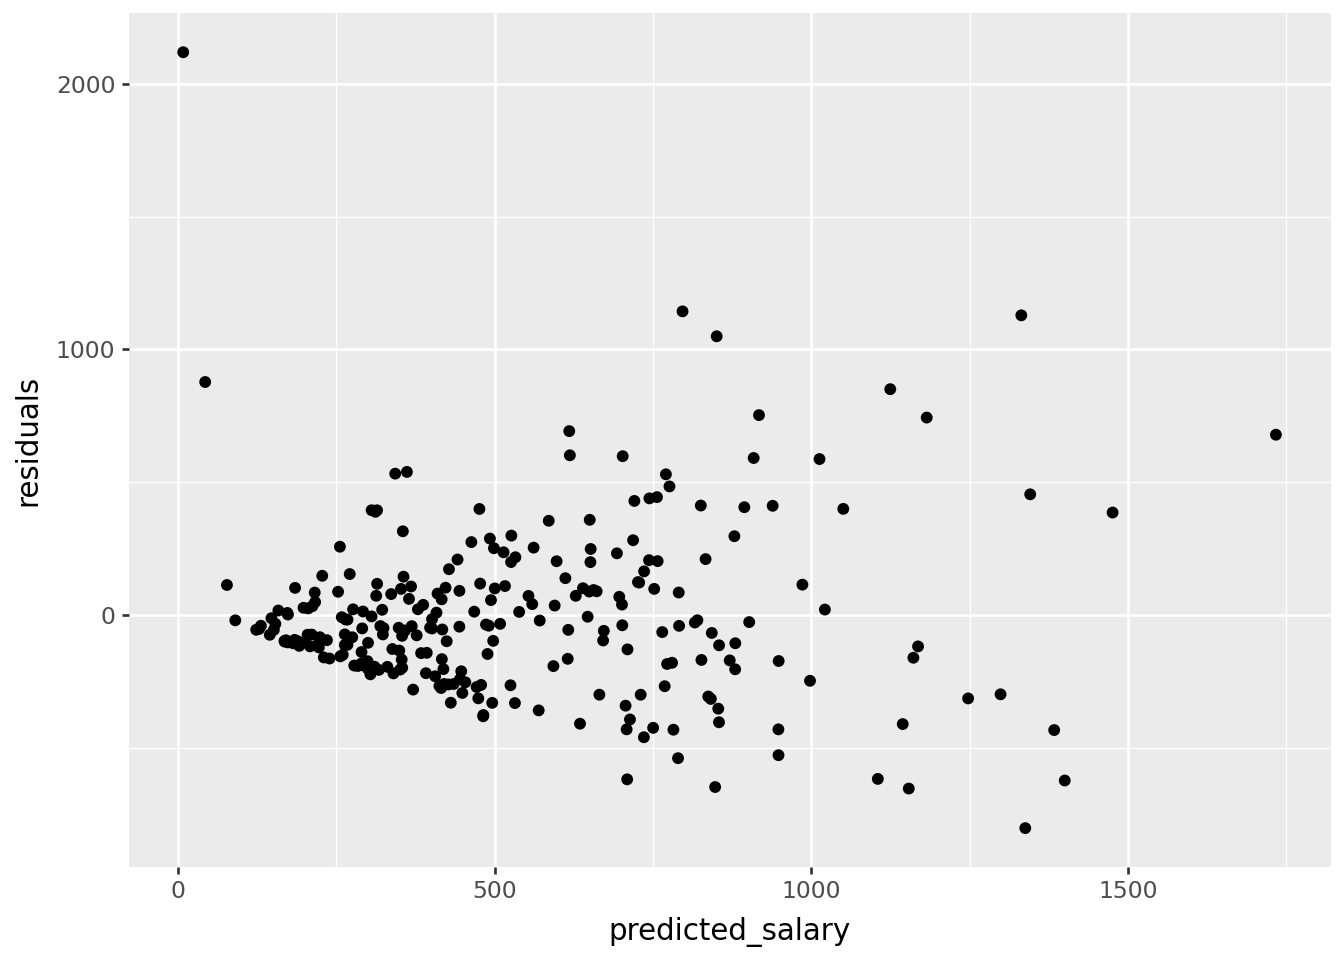

In [40]:
y_pred = winner_fitted.predict(hitters.drop(["Salary"], axis = 1))

(ggplot(hitters_copy,
aes(x = 'predicted_salary', y = 'residuals'))
+ geom_point()
)

From the residuals x predicted plot, we are able to see sure signs of heteroskedasticity, meaning that as our predicted salary increases, the error for which we predict is greater. This makes sense with the variation in statisitcs of different players.